In [16]:
import os
import veloxchem as vlx
import openmm as mm
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.transform as scitransform
import matplotlib.colors as mcolors

# todo think of how this can be structured
from EVB.evb_driver import EVB_driver
from EVB.system_builder import System_builder, solvents
import EVB.data_processing as dp
import openmm.app as mmapp

## Birds eye overview

The goal of Empirical Valence Bond(EVB) theory is to explicitly calculate the effects of the environment on a chemical reaction. This is of great value in the research of catalysts and enzymes. EVB does this through a free energy perturbation (FEP) using molecular mechanics force fields. This does however not capture the chemical bond energy, which is added post hoc from reference data. This generalises across multiple environments, which allows for obtaining new results. The workflow is thus as follows
1. Build a forcefield for the reactant and the product
2. Perform a free energy perturbation from the reactant to the product forcefield in various environments, such as vacuum, water and DMF
3. Fit one of the results, for example those of vacuum, to known results from for example DFT
4. Apply the same correction to the other results from water and DMF

Let's take the chloride bromide substitution of methane as an example, which is a standard $\mathrm{S_N }2$ reaction.
$$\mathrm{Br}^-+\mathrm{CH}_3\mathrm{Cl}\rightarrow \mathrm{CH}_3\mathrm{Br}+\mathrm{Cl}^-.$$
The first step is to set up the EVB driver and build the forcefields for the reactant and product. 

In [2]:
EVB = EVB_driver()

EVB.build_forcefields(reactant="CH3Cl_Br", product="CH3Br_Cl", charge=-1)

Loading charges from forcefield_data/CH3Cl_Br_charges.txt file, total charge = -1.0
Loading force field data from forcefield_data/CH3Cl_Br_ff_data.json file
Force field data found, not reparameterising.
Loading charges from forcefield_data/CH3Br_Cl_charges.txt file, total charge = -1.0
Loading force field data from forcefield_data/CH3Br_Cl_ff_data.json file
Force field data found, not reparameterising.
1 breaking bonds:
ProType, ReaType, ID	 - ProType, ReaType, ID
c3	c3	0 	 - cl	cl	5
1 forming bonds:
ProType, ReaType, ID	 - ProType, ReaType, ID
c3	c3	0 	 - br	br	4


The charge parameter is the total charge of the system in $e$. The reactant and product strings correspond to the filenames of the xyz files in theinput_files folder, which is where the GAFF data file should be located as well. The geometries in the xyz files are used to automatically generate the forcefields. First the connectivity of the molecule is detected, after which all appropriate GAFF parameters are assigned. Every parameter not found in the GAFF file is reparameterised using the Seminario method for which the hessian is approximated with xTB. The charges are calculated using the RESP method. It then prints out which bonds are broken and/or formed. 

These forcefields form energy surfaces $\mathcal{E}_1$ and $\mathcal{E}_2$ for the reactant and product respectively. When simulating dynamics in $\mathcal{E}_1$, the system would never end up in regions of phase space for $\mathcal{E}_2$ and vice versa. Thus to reach the whole fo phase space uring the free energy perturbation, the system is slowly pushed from $\mathcal{E}_1$ to $\mathcal{E}_2$ using the mapping potential
$$
V(\lambda)=(1-\lambda)\mathcal{E}_1+\lambda\mathcal{E}_2.
$$
where $0\leq\lambda\leq1$. This is also known as umbrella sampling. By performing a sampling for a range of $\lambda$ values, the complete region of interest in phase space can be sampled. For every $\lambda$ frame, a forcefield needs to be generated which is done with the following code

In [17]:
EVB.build_systems(
    Lambda=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    temperature=300,  # kelvin
)

With the forcefields ready, the sampling can be performed. This goes as follows.

1. Start with the reactant structure
2. For every λ value:
   1. Minimise the energy 
   2. Equilibrate the system for an amount of steps given in `equil_steps`
   3. Run the system for an amount of steps given in `total_sample_steps`
   4. Record the geometry and energy at a given interval of steps given in `write_step`
   5. Take the final structure as the initial structure for the next lambda value 
3. Recalculate the energy of every recorded geometry

The recalculation is performed to get accurate energies while speeding up convergence. Constraints that limit the phase space, including automatically added distance restraints, shrink down the reachable portion of phase space, which increases convergence of average properties. However, these forces should not contribute to the free energy. For this reason, after having collected the frames of trajectories, the energy is recalculated with a potential that does not include these constraints. 
<!-- TODO Furthermore, the nonbonded potential that are used for the recalculation is a soft-core variant.  
The standard formulation of the non-bonded potential causes poor convergence. Because equations \eqref{eq:LJ} and \eqref{eq:Q} go to infinity as $r$ goes to 0, the endpoint energies that equation  depends on diverge. For example in the \Snt reaction in the reactant state for $\lambda=0$, the carbon and chloride are bound and the Morse-potential contributing to $\mathcal{E}_1$ will be close to the minimum. However, the nonbonded potential between the same atoms contributing to $\mathcal{E}_2$ will be extremely large, and thus the profile of $\Delta E$ over increasing $\lambda$ will be very steep, which causes poor convergence. The soft-core correction presented in Section \ref{sec:soft_core} solves this issue. The soft-core potential has a finite value at $r=0$, leading to smoother energy profiles. This however causes another problem, as the soft-core potential does not simulate the proper dynamics. To solve this, the system is simulated and sampled using the normal nonbonded potential. After that, the energies of the obtained geometries are recalculated using a soft-core potential. Generally speaking, \Vsample can be defined as the sampling potential which has hard-core nonbonded interactions, and \Vrecalc as the recalculation potential which has soft-core nonbonded interactions. This procedure allows to pick and choose which potentials should contribute to dynamics, and which potentials should contribute to the free energy profile. By default the soft-core parameters are set to $\alpha_{LJ}=0.85$, $\alpha_{Q}=0.3$, $\sigma_{Q}=1$, and $p=1/6$ and can be adjusted by the user. 
-->

In [18]:
EVB.run_FEP(
    equil_steps=100,
    total_sample_steps=2000,  # amount of timesteps per lambda
    write_step=100,  # amount of timesteps per snapshot
    step_size=0.001,  # in ps
)

Lambda:  [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Total lambda points:  11
Snapshots per lambda:  20.0
Snapshots to be recorded:  220.0
Total simulation steps:  23100
System time per snapshot:  0.1  ps
System time per frame:  2.0  ps
Total system time:  22.0  ps
lambda = 0.0
Minimizing energy
Running equilliberation
Running sampling
lambda = 0.1, estimated time remaining: 3 second(s)
Minimizing energy
Running equilliberation
Running sampling
lambda = 0.2, estimated time remaining: 2 second(s)
Minimizing energy
Running equilliberation
Running sampling
lambda = 0.3, estimated time remaining: 2 second(s)
Minimizing energy
Running equilliberation
Running sampling
lambda = 0.4, estimated time remaining: 2 second(s)
Minimizing energy
Running equilliberation
Running sampling
lambda = 0.5, estimated time remaining: 2 second(s)
Minimizing energy
Running equilliberation
Running sampling
lambda = 0.6, estimated time remaining: 1 second(s)
Minimizing energy
Running equilliberation
R

<!-- TODO show video of pdb -->
Next a system solvated in water is set up using again the `build_systems` function, but with some extra parameters. A to build a periodic box of 100 water molecules at a density of 997 kg/m^3. Because the total charge of the reaction is -e, an Na+ counterion is added automatically. Next to that, a constraint is specified to keep the chloride-carbon-bromide angle at 180 degrees with a weak harmonic potential. This is to make sure the atoms stay in the right orientation even as the solvent will interact and potentially push the bromide or chloride out of the natural approach vector. It is also possible add a graphene sheet to the system in this step.

<!-- "solvated": solvated,
"solvent_smiles": solvent_smiles,
"solvent_count": solvent_count,
"solvent_density": solvent_density,
"solvent_nb_cutoff": solvent_nb_cutoff,
"solvent_nb_switch_factor": solvent_nb_switch_factor, -->

In [19]:
EVB.build_systems(
    Lambda=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    temperature=300,  # kelvin
    pressure=1,  # bar
    solvated=True,
    solvent_smiles=["[OH2]"],  # smiles of the solvent molecules
    solvent_count=[100],  # number of solvent molecules
    solvent_density=997,  # kg/m^3
    constraints={(4, 0, 5): {"force_constant": 20, "equilibrium": 180}},
)

The formal charge for atom 4 is set to -1
Starting packing system
Finished packing system
Creating system
No nonbonded cutoff given, setting to 0.7410779241615687 nm (half of the box size with a maximum of 1.5 nm)
Finished creating system


Now the dynamics for the solvated system can be ran. Here two new parameters were added. The initial equiliberation is necessary to make sure the counterion is properly solvated in the system. The platform parameter specifies the hardware platform to run the FEP simulation on. OpenMM has GPU acceleration for CUDA and OpenCL, and otherwise it can be ran on the CPU. With solvated systems it is recommended to use GPU accelertion if available. It is advised inspect these results as well, before going on to a production run requiring more computational resources. In particular the tuning of a constraint force might require some trial and error.

In [20]:
EVB.run_FEP(
    initial_equil_steps=10000,
    equil_steps=100,
    total_sample_steps=2000,  # amount of timesteps per lambda
    write_step=100,  # amount of timesteps per snapshot
    step_size=0.001,  # in ps
    platform="CPU",
)

Lambda:  [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Total lambda points:  11
Snapshots per lambda:  20.0
Snapshots to be recorded:  220.0
Total simulation steps:  33100
System time per snapshot:  0.1  ps
System time per frame:  2.0  ps
Total system time:  22.0  ps
lambda = 0.0
Minimizing energy
Running equilliberation
Running sampling
lambda = 0.1, estimated time remaining: 1 minute(s), 42 second(s)
Minimizing energy
Running equilliberation
Running sampling
lambda = 0.2, estimated time remaining: 53 second(s)
Minimizing energy
Running equilliberation
Running sampling
lambda = 0.3, estimated time remaining: 37 second(s)
Minimizing energy
Running equilliberation
Running sampling
lambda = 0.4, estimated time remaining: 27 second(s)
Minimizing energy
Running equilliberation
Running sampling
lambda = 0.5, estimated time remaining: 21 second(s)
Minimizing energy
Running equilliberation
Running sampling
lambda = 0.6, estimated time remaining: 16 second(s)
Minimizing energy
Runnin

Then once the production run is finished, the data can be analysed.

## From valence bond to empirical valence bond theory
In valence bond theory, the wavefunction of the reaction system can be written as follows
$$
    \Phi_1=[\mathrm{Cl}\mathrm{CH}_3+\mathrm{Br}^-]\chi_1\\
    \Phi_2=[\mathrm{Cl}^-+\mathrm{CH}_3\mathrm{Br}]\chi_2\\
    \Phi_3=[\mathrm{Cl}^-+\mathrm{CH}_3^++\mathrm{Br}^-]\chi_3\\
    \Phi_4=[\mathrm{Cl}\mathrm{Br}+\mathrm{CH}_3^-]\chi_4\\
    \Phi_5=[\mathrm{Cl}^++\mathrm{CH}_3^-+\mathrm{Br}^-]\chi_5\\
    \Phi_6=[\mathrm{Cl}^-+\mathrm{CH}_3^-+\mathrm{Br}^+]\chi_6
$$
Of all states $\Phi_i$, $\Phi_1$, $\Phi_2$ and $\Phi_3$ are energetically the lowest lying states. This can be shown rigorously. However, intuitively this can be seen because $\Phi_5$ and $\Phi_6$ have a severe energy penalty from their charge distribution. Furthermore, $\Phi_4$ has a covalent bond between the ions which in any physical geometry will be stretched significantly because the nucleophile and leaving group will be on opposite sides of the system. With the assumption that this can be compensated at a later stage through parameterisation, these wavefunctions are discarded from the ansatz of the wavefunction. It is then assumed that
$$
\Psi_1=\alpha_1\Phi_1+\beta_2\Phi_3\\
\Psi_2=\alpha_2\Phi_2+\beta_2\Phi_3
$$
where $\Psi_1$ and $\Psi_2$ are the reactant and product wavefunctions. Writing $\bar{\Psi} = (\Psi_1,\Psi_2)^T$, this can be inserted in the Schrödinger equation and solved for the lowest eigenvalue to obtain the ground state energy
$$
\left\vert
        \begin{matrix}
            \langle\Psi_1|H|\Psi_1\rangle -E_g & \langle\Psi_1|H|\Psi_2\rangle -E_g \langle\Psi_1|\Psi_2\rangle  \\
            \langle\Psi_2|H|\Psi_1\rangle -E_g \langle\Psi_2|\Psi_1\rangle & \langle\Psi_2|H|\Psi_2\rangle-E_g \\
        \end{matrix}
    \right\vert
    =
    \left\vert
        \begin{matrix}
            H_{11} -E_g & H_{21} \\
            H_{12} & H_{22} -E_g\\
        \end{matrix}
    \right\vert
    = 0
$$
where without loss of generality the overlap integrals are absorbed into the off-diagonal elements as
$$
H_{21}=H_{12}=\langle\Psi_1|H|\Psi_2\rangle -E_g \langle\Psi_1|\Psi_2\rangle=C
$$
In ab initio methods, one would continue by evaluating these matrix elements with standard quantum chemical methods. However, this is bound to produce bad results due to the assumptions of the form of the wavefunction. Instead, in the EVB-framework these matrix elements are empirically formulated. 
$$
H_{11}=U_1(\bar{R})=\mathcal{E}_1(\bar{R})\\
H_{22}=U_2(\bar{R})+\alpha=\mathcal{E}_2(\bar{R})\\
$$
Here, $\alpha$ is the gas phase energy difference between $\mathcal{E}_1$ and $\mathcal{E}_2$. The ground state energy can then be expressed as
$$
E_g(\bar{R},H_{12},\alpha)=\frac{1}{2} \left[(\mathcal{E}_1(\bar{R})+\mathcal{E}_2(\bar{R},\alpha))-\sqrt{(\mathcal{E}_1(\bar{R})-\mathcal{E}_2(\bar{R},\alpha)^2+4 H_{12}^2}\right]
$$
A crucial point here is that once a parameterisation for the system has been obtained in terms of $\mathcal{E}_1$, $\mathcal{E}_2$ , $H_{12}$, the matrix elements are only dependent on the geometry of the system and not on the environment anymore. This makes it a potentially very powerful method.

<!-- Below is a schematic representation of the two diabatic ground states and the associated ground state energy plotted against the generalised reaction coordinate $\Delta E = \mathcal{E}_1-\mathcal{E}_2$ on the x-axis. The positive nonzero value of $H_{12}$ causes coupling between $\mathcal{E}_1$ and $\mathcal{E}_2$ and lowers the peak of $E_g$. The diagonal elements are formulated as a sum of force field contributions as -->

![Diabats](./img/Diabats.png)



## Calculating the free energy profile

<!-- The free energy profile is calculated with the Bennett Acceptance ratio implemented in the pymbar package \parencite{pymbar}. The results are returned in a python dictionary, and the module has built-in functions to print and plot the results. For a discussion on interpreting the results, please see Section \ref{sec:results}. -->
he final aim is to obtain the profile of the free energy difference associated with the groundstate of the system which is expressed in terms of an ensemble average
$$
\Delta G_{\mathrm{EVB}} = -\beta\ln\frac{Z_g}{Z_1}= -\beta\ln\langle e^{-\beta(E_g-\mathcal{E}_1)}\rangle_{\mathcal{E}_1}
$$
where $Z_g$ and $Z_1$ are the configurational integrals associated with the $E_g$ and $\mathcal{E}_1$. This profile, just like $E_g$ itself, has 2 local minima and one local maximum corresponding with the reactant and product state, and the transition state respectively. But $E_g$ is unknown because α and $H_{12}$ are unknown. One could sample (54) for a range of α and $H_{12}$ to then pick the best pair of parameters matching with empirical results, but this would require a large number of samplings. Ideally otnly one free energy calculation would be performed to then fit α and $H_{12}$ to the profile. So instead, the equation is rephrased to something that is computable
$$
\Delta G_{\mathrm{FEP}}(1 \rightarrow 2)=-\beta^{-1}\ln \langle e^{-\beta(\mathcal{E}_2-\mathcal{E}_1)}\rangle_{\mathcal{E}_1}
$$
$$
\Delta G_{\mathrm{FEP}} (\lambda_0\rightarrow \lambda_n)=-\beta^{-1}\sum_{n=0}^{N-1}{\ln\langle e^{-\beta(V_{n+1}-V_n)}\rangle_{V_n}}\\

\Delta G_{\mathrm{EVB}}(\Delta E)=\mu(\Delta E)+\Delta G_{\mathrm{FEP}}\left(\nu(\Delta E)\right)\\
\mu(x)=\frac{1}{2}(-\sqrt{4 H_{12}^2+x^2}+\frac{x^2}{\sqrt{4 H_{12}^2+x^2}})\\
\nu(x)=\frac{x}{2\sqrt{4 H_{12}^2+x^2}}+\frac{1}{2}\\
$$

Sample data in CH3_Sn2_data used

In [8]:
Sn2_alpha, Sn2_H12 = dp.fit_EVB_parameters(
    T=300,
    reference=f"./CH3_Sn2_data/Vacuum",
    free_energy=2,
    barrier=10,
)

iteration 1 	 alpha: 8.88819 	 H12: 4.95740 	 	 barrier: 25.04260 	 free energy: -6.88819
iteration 2 	 alpha: 8.77828 	 H12: -27.68452 	 	 barrier: 42.64192 	 free energy: 2.10991
iteration 3 	 alpha: 9.28519 	 H12: -40.90674 	 	 barrier: 23.22222 	 free energy: 1.49309
iteration 4 	 alpha: 9.83803 	 H12: -45.56935 	 	 barrier: 14.66261 	 free energy: 1.44716
iteration 5 	 alpha: 10.11844 	 H12: -47.88291 	 	 barrier: 12.31356 	 free energy: 1.71959
iteration 6 	 alpha: 10.26693 	 H12: -49.13734 	 	 barrier: 11.25443 	 free energy: 1.85151
iteration 7 	 alpha: 10.35639 	 H12: -49.83724 	 	 barrier: 10.69989 	 free energy: 1.91054
iteration 8 	 alpha: 10.40779 	 H12: -50.24029 	 	 barrier: 10.40305 	 free energy: 1.94860
iteration 9 	 alpha: 10.43959 	 H12: -50.47391 	 	 barrier: 10.23362 	 free energy: 1.96820
iteration 10 	 alpha: 10.45847 	 H12: -50.61069 	 	 barrier: 10.13679 	 free energy: 1.98113
iteration 11 	 alpha: 10.46960 	 H12: -50.69107 	 	 barrier: 10.08038 	 free energy:

These values are then used to calculate the free energy profile and the EVB profile of the other measurements.

Discrete	 Barrier 		 Free Energy


Analytical	 Barrier 		 Free Energy
Vacuum     	 9.998808910261431 	 2.0008584242374923
Water      	 23.505383682794108 	 -2.963876043434336
DMF        	 19.139846819736366 	 4.833225820794194
Acetone    	 20.675508451508684 	 8.982534871241954


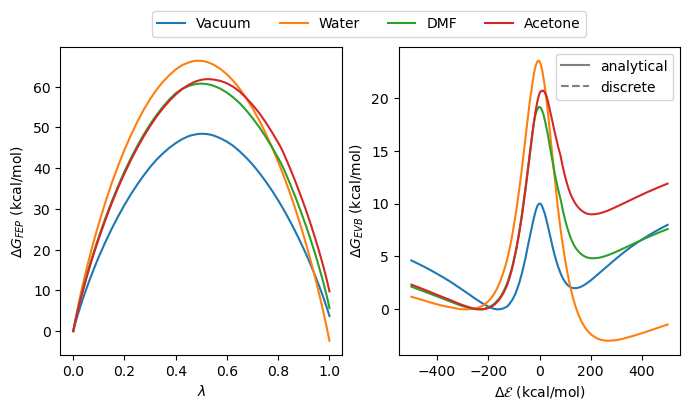

In [14]:
results = dp.get_FEP_and_EVB(
    folders=[
        f"./CH3_Sn2_data/Vacuum",
        f"./CH3_Sn2_data/Water",
        f"./CH3_Sn2_data/DMF",
        f"./CH3_Sn2_data/Acetone",
    ],
    alpha=Sn2_alpha,
    H12=Sn2_H12,
)
dp.print_EVB_results(results)
dp.plot_EVB(
    results,
)

Discrete	 Barrier 		 Free Energy
Vacuum     	 9.86537253876194 	 1.9288182504998552
Water      	 23.42706202248725 	 -2.9766028775241846
DMF        	 19.01452975870898 	 4.737573552636151
Acetone    	 20.50265932188273 	 8.945485987326606


Analytical	 Barrier 		 Free Energy
Vacuum     	 9.940941938352506 	 1.9985765086423655
Water      	 23.4750226217677 	 -2.9642544707001193
DMF        	 19.01907542881299 	 4.8295859551222
Acetone    	 20.627718407725972 	 8.983476719210975


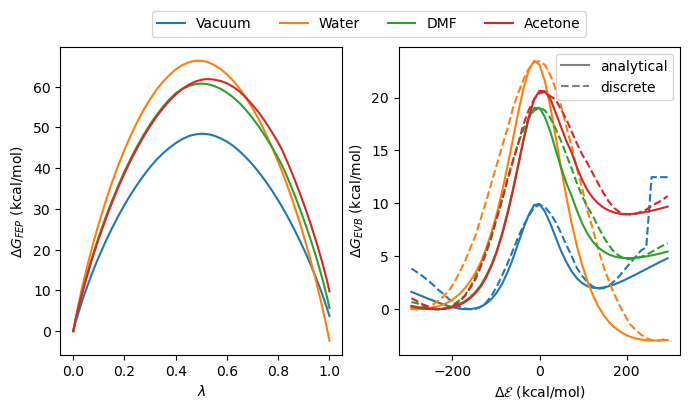

In [15]:
results = dp.get_FEP_and_EVB(
    folders=[
        f"./CH3_Sn2_data/Vacuum",
        f"./CH3_Sn2_data/Water",
        f"./CH3_Sn2_data/DMF",
        f"./CH3_Sn2_data/Acetone",
    ],
    alpha=Sn2_alpha,
    H12=Sn2_H12,
    discretised=True,
    coordinate_bins=np.linspace(-300, 300, 50),
)
dp.print_EVB_results(results)
dp.plot_EVB(
    results,
    coordinate_bins=np.linspace(-300, 300, 50),
    plot_discrete=True,
)